## 폐렴 진단해보기!!

### 라이브러리 선언

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


### 데이터 가져오기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화하기!

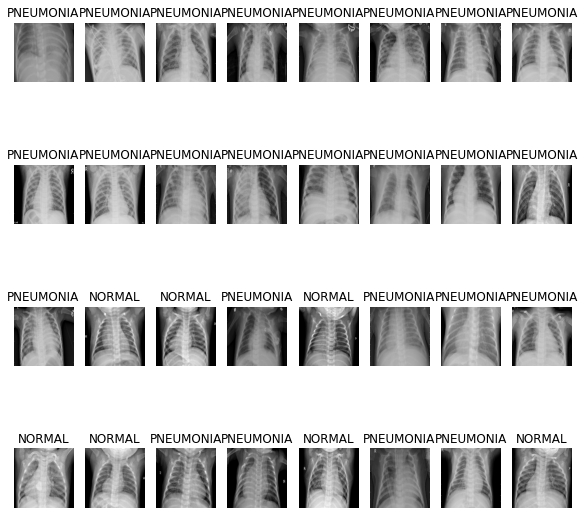

In [52]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [54]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리하기!

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 64s 194ms/step - loss: 0.4104 - accuracy: 0.8108 - precision: 0.9585 - recall: 0.7797 - val_loss: 0.6924 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2548 - accuracy: 0.8968 - precision: 0.9684 - recall: 0.8900 - val_loss: 1.2142 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2136 - accuracy: 0.9219 - precision: 0.9764 - recall: 0.9173 - val_loss: 1.0677 - val_accuracy: 0.6596 - val_precision: 1.0000 - val_recall: 0.5379
Epoch 4/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1808 - accuracy: 0.9260 - precision: 0.9801 - recall: 0.9193 - val_loss: 0.1084 - val_accuracy: 0.9529 - val_precision: 0.9442 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 52s 201ms/step - loss: 0.1750 - accura

### 결과 확인하기!

=3


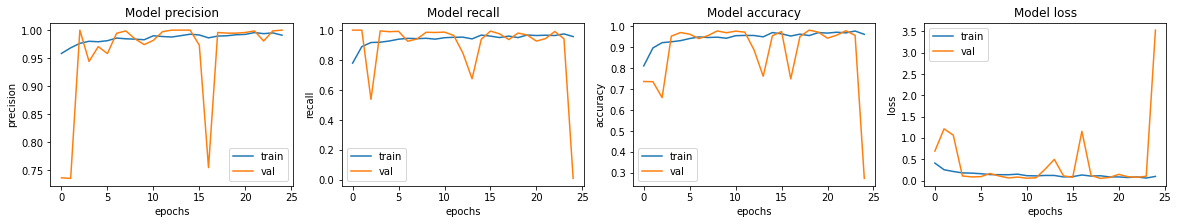

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
print("=3")

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 2.8300 - accuracy: 0.3894 - precision: 1.0000 - recall: 0.0231
Loss: 2.830004930496216,
Accuracy: 0.38942307233810425,
Precision: 1.0,
Recall: 0.023076923564076424


## 폐렴진단기 성능 개선해보기!

In [15]:
# BATCH_SIZE = 32
# EPOCHS = 15

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Batch size, Epoch, prepare_for_training를 변경해주었다.

=3


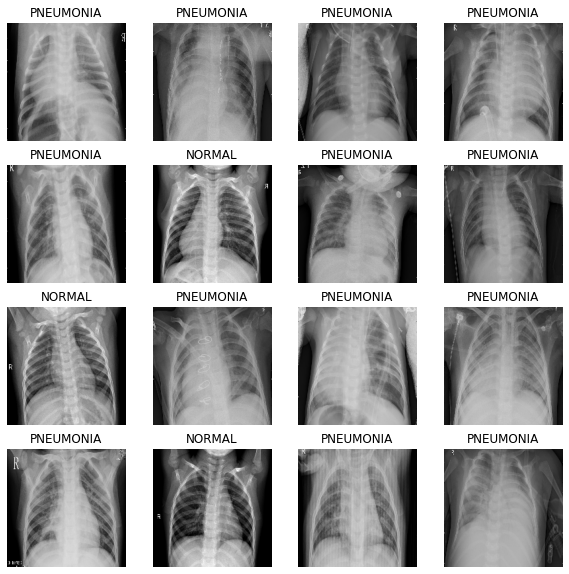

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

print("=3")

데이터 시각화를 해보았다.

In [18]:
def dense_block1(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

print("=3")

=3


In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

print("=3")

=3


데이터 imbalance 처리해주기

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


print("=3")

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67
=3


모델 훈련시키기

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 63s 380ms/step - loss: 0.4602 - accuracy: 0.7846 - precision: 0.9414 - recall: 0.7576 - val_loss: 0.5852 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 50s 384ms/step - loss: 0.2670 - accuracy: 0.8950 - precision: 0.9687 - recall: 0.8878 - val_loss: 0.7191 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 50s 384ms/step - loss: 0.2001 - accuracy: 0.9224 - precision: 0.9775 - recall: 0.9163 - val_loss: 0.8643 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 51s 395ms/step - loss: 0.1711 - accuracy: 0.9370 - precision: 0.9778 - recall: 0.9369 - val_loss: 1.1087 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 55s 422ms/step - loss: 0.1561 - accura

=3


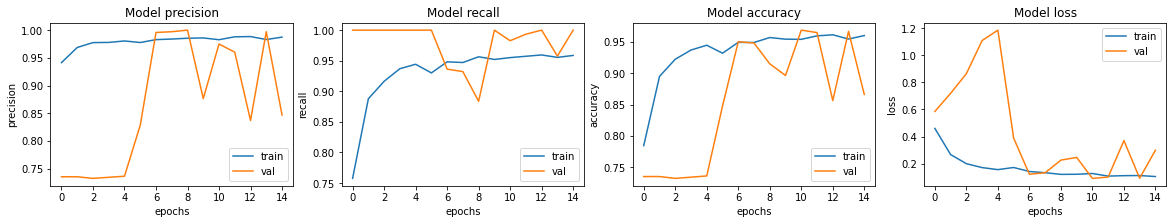

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
print("=3")

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 221ms/step - loss: 1.2643 - accuracy: 0.6410 - precision: 0.6352 - recall: 1.0000
Loss: 1.2642773389816284,
Accuracy: 0.6410256624221802,
Precision: 0.6351791620254517,
Recall: 1.0


#### 결과가 맘에 들지 않아서 몇번 수정해보려고 한다.

In [27]:
BATCH_SIZE = 64
EPOCHS = 15

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [28]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)

In [29]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/15
65/65 [==============================] - 38s 446ms/step - loss: 0.6249 - accuracy: 0.6712 - precision: 0.8982 - recall: 0.6285 - val_loss: 0.6620 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 2/15
65/65 [==============================] - 28s 438ms/step - loss: 0.3398 - accuracy: 0.8245 - precision: 0.9677 - recall: 0.7914 - val_loss: 0.5853 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/15
65/65 [==============================] - 28s 440ms/step - loss: 0.2585 - accuracy: 0.8952 - precision: 0.9723 - recall: 0.8844 - val_loss: 0.6641 - val_accuracy: 0.7285 - val_precision: 0.7285 - val_recall: 1.0000
Epoch 4/15
65/65 [==============================] - 29s 452ms/step - loss: 0.2225 - accuracy: 0.9144 - precision: 0.9749 - recall: 0.9077 - val_loss: 0.7220 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000


In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 219ms/step - loss: 1.0474 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.0473836660385132,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [35]:
BATCH_SIZE = 16
EPOCHS = 5

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.MaxPool2D((2,2)),
        conv_block(64),
        tf.keras.layers.MaxPool2D((2,2)),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [36]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/5
261/261 [==============================] - 100s 347ms/step - loss: 0.4108 - accuracy: 0.8029 - precision: 0.9466 - recall: 0.7789 - val_loss: 0.6085 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 90s 345ms/step - loss: 0.1894 - accuracy: 0.9296 - precision: 0.9773 - recall: 0.9269 - val_loss: 0.9318 - val_accuracy: 0.7370 - val_precision: 0.7370 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 90s 345ms/step - loss: 0.1591 - accuracy: 0.9425 - precision: 0.9812 - recall: 0.9408 - val_loss: 0.1004 - val_accuracy: 0.9702 - val_precision: 0.9687 - val_recall: 0.9915
Epoch 4/5
261/261 [==============================] - 90s 347ms/step - loss: 0.1329 - accuracy: 0.9532 - precision: 0.9834 - recall: 0.9531 - val_loss: 0.0892 - val_accuracy: 0.9707 - val_precision: 0.9920 - val_recall: 0.9680
Epoch 5/5
261/261 [==============================] - 93s 356ms/step - loss: 0.1144 - accuracy: 

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 212ms/step - loss: 0.3886 - accuracy: 0.8686 - precision: 0.8565 - recall: 0.9487
Loss: 0.388581246137619,
Accuracy: 0.8685897588729858,
Precision: 0.8564814925193787,
Recall: 0.9487179517745972


### 여러가지 파라미터를 수정하며 나타낸 점수이다.

In [44]:
BATCH_SIZE = 16
EPOCHS = 20

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
#         tf.keras.layers.MaxPool2D((2,2)),
        conv_block(64),
#         tf.keras.layers.MaxPool2D((2,2)),
        
        conv_block(128),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [45]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)

In [46]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/20
261/261 [==============================] - 59s 191ms/step - loss: 0.5585 - accuracy: 0.7081 - precision: 0.9049 - recall: 0.6793 - val_loss: 0.5859 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 192ms/step - loss: 0.3505 - accuracy: 0.8487 - precision: 0.9578 - recall: 0.8332 - val_loss: 0.7816 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 50s 192ms/step - loss: 0.2787 - accuracy: 0.8853 - precision: 0.9677 - recall: 0.8753 - val_loss: 0.3313 - val_accuracy: 0.8221 - val_precision: 0.8053 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 50s 190ms/step - loss: 0.2238 - accuracy: 0.9104 - precision: 0.9756 - recall: 0.9021 - val_loss: 0.4178 - val_accuracy: 0.8192 - val_precision: 1.0000 - val_recall: 0.7533
Epoch 5/20
261/261 [==============================] - 50s 193ms/step - loss: 0.2114 - accura

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 191ms/step - loss: 1.0899 - accuracy: 0.6506 - precision: 0.9831 - recall: 0.4487
Loss: 1.0899232625961304,
Accuracy: 0.6506410241127014,
Precision: 0.983146071434021,
Recall: 0.44871795177459717


In [52]:
BATCH_SIZE = 16
EPOCHS = 20

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.MaxPool2D((2,2)),
        conv_block(64),
        tf.keras.layers.MaxPool2D((2,2)),
        
        conv_block(128),
#         tf.keras.layers.MaxPool2D((2,2)),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.MaxPool2D((2,2)),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [53]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)

In [54]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/20
261/261 [==============================] - 58s 188ms/step - loss: 0.3255 - accuracy: 0.8508 - precision: 0.9690 - recall: 0.8259 - val_loss: 0.5839 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 49s 188ms/step - loss: 0.2177 - accuracy: 0.9186 - precision: 0.9753 - recall: 0.9138 - val_loss: 0.7957 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 48s 185ms/step - loss: 0.2153 - accuracy: 0.9171 - precision: 0.9726 - recall: 0.9144 - val_loss: 0.1932 - val_accuracy: 0.9183 - val_precision: 0.9017 - val_recall: 0.9974
Epoch 4/20
261/261 [==============================] - 49s 190ms/step - loss: 0.1787 - accuracy: 0.9356 - precision: 0.9810 - recall: 0.9315 - val_loss: 0.3498 - val_accuracy: 0.8731 - val_precision: 1.0000 - val_recall: 0.8268
Epoch 5/20
261/261 [==============================] - 50s 193ms/step - loss: 0.1780 - accura

In [55]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.3668 - accuracy: 0.8638 - precision: 0.8622 - recall: 0.9308
Loss: 0.36677685379981995,
Accuracy: 0.8637820482254028,
Precision: 0.8622328042984009,
Recall: 0.9307692050933838


In [58]:
BATCH_SIZE = 16
EPOCHS = 20

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        tf.keras.layers.MaxPool2D((2,2)),
        conv_block(128),
        tf.keras.layers.MaxPool2D((2,2)),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [59]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)

In [60]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/20
261/261 [==============================] - 59s 190ms/step - loss: 0.5770 - accuracy: 0.7143 - precision: 0.9008 - recall: 0.6925 - val_loss: 0.6069 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 191ms/step - loss: 0.3054 - accuracy: 0.8769 - precision: 0.9609 - recall: 0.8700 - val_loss: 0.8613 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 49s 189ms/step - loss: 0.2335 - accuracy: 0.9057 - precision: 0.9712 - recall: 0.8999 - val_loss: 0.1686 - val_accuracy: 0.9394 - val_precision: 0.9902 - val_recall: 0.9265
Epoch 4/20
261/261 [==============================] - 50s 191ms/step - loss: 0.2172 - accuracy: 0.9219 - precision: 0.9735 - recall: 0.9203 - val_loss: 0.8296 - val_accuracy: 0.7942 - val_precision: 1.0000 - val_recall: 0.7192
Epoch 5/20
261/261 [==============================] - 50s 192ms/step - loss: 0.1853 - accura

In [61]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 1.1429 - accuracy: 0.6571 - precision: 0.6457 - recall: 1.0000
Loss: 1.1428560018539429,
Accuracy: 0.6570512652397156,
Precision: 0.6456953883171082,
Recall: 1.0


In [62]:
BATCH_SIZE = 16
EPOCHS = 20

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.MaxPool2D(),
        conv_block(64),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [63]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)

In [64]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/20
261/261 [==============================] - 58s 190ms/step - loss: 0.5798 - accuracy: 0.7088 - precision: 0.9049 - recall: 0.6801 - val_loss: 0.6470 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 49s 187ms/step - loss: 0.3000 - accuracy: 0.8901 - precision: 0.9649 - recall: 0.8846 - val_loss: 0.7721 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 49s 189ms/step - loss: 0.2432 - accuracy: 0.9047 - precision: 0.9676 - recall: 0.9022 - val_loss: 0.1820 - val_accuracy: 0.9115 - val_precision: 0.8931 - val_recall: 0.9987
Epoch 4/20
261/261 [==============================] - 50s 190ms/step - loss: 0.1916 - accuracy: 0.9310 - precision: 0.9767 - recall: 0.9295 - val_loss: 0.0810 - val_accuracy: 0.9731 - val_precision: 0.9933 - val_recall: 0.9699
Epoch 5/20
261/261 [==============================] - 50s 192ms/step - loss: 0.1813 - accura

In [65]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 98ms/step - loss: 0.3385 - accuracy: 0.8702 - precision: 0.8723 - recall: 0.9282
Loss: 0.3385404050350189,
Accuracy: 0.870192289352417,
Precision: 0.8722891807556152,
Recall: 0.928205132484436


In [69]:
BATCH_SIZE = 16
EPOCHS = 5

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.MaxPool2D(),
        conv_block(64),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block1(512, 0.7),
        dense_block1(128, 0.5),
        dense_block1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [70]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#     es = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',patience=2
# )

In [71]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
#         callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/5
261/261 [==============================] - 57s 185ms/step - loss: 0.5199 - accuracy: 0.7505 - precision: 0.9233 - recall: 0.7248 - val_loss: 0.5912 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 48s 185ms/step - loss: 0.2680 - accuracy: 0.8870 - precision: 0.9680 - recall: 0.8771 - val_loss: 0.9894 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 48s 184ms/step - loss: 0.2082 - accuracy: 0.9193 - precision: 0.9737 - recall: 0.9163 - val_loss: 0.1922 - val_accuracy: 0.9183 - val_precision: 0.8999 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 48s 186ms/step - loss: 0.1980 - accuracy: 0.9250 - precision: 0.9781 - recall: 0.9200 - val_loss: 0.1070 - val_accuracy: 0.9644 - val_precision: 0.9932 - val_recall: 0.9581
Epoch 5/5
261/261 [==============================] - 49s 188ms/step - loss: 0.1784 - accuracy: 0

In [72]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.8639 - accuracy: 0.7099 - precision: 0.6837 - recall: 0.9974
Loss: 0.8639205694198608,
Accuracy: 0.7099359035491943,
Precision: 0.6836555600166321,
Recall: 0.9974358677864075


## 결과 및 회고
39/39 [==============================] - 4s 98ms/step - loss: 0.3385 - accuracy: 0.8702 - precision: 0.8723 - recall: 0.9282 <br/>
Loss: 0.3385404050350189, <br/>
Accuracy: 0.870192289352417, <br/>
Precision: 0.8722891807556152, <br/>
Recall: 0.928205132484436

다양한 시도를 해보았으나 최고 높게 나온 결과는 이렇다.. 아쉽게도 90%에 도달하지 못했다. 다양한 전처리나 optimizer, learning late를 수정하거나 좀 더 다양하게 해보았으면 좋았을텐데 여기에 시간을 너무 많이 쏟는 것 같아서 여기까지 했다. 그래도 다양한 파라미터 값들을 수정하면서 어떤 부분에서 과적합이 일어나고 loss를 낮출 수 있는지, vaildation data의 결과가 더 좋게 나오는지 깨닫게 되어 뜻깊은 실험이 되었다고 생각한다. 주말이나 시간이 날때 좀 더 수정을 통해서 90%에 도달하기 위한 방법을 모색해보아야겠다..!  